# Kilonova simulations 

## Import and initialize variables 

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py
import os
import matplotlib.animation as animation

plt.rcParams['axes.grid'] = True
plt.rcParams['animation.html'] = 'html5'

In [2]:
# import from other files 
from ipynb.fs.full.Neutron_Star_SPH_sph import W, gradW, getPairwiseSeparations, getDensity
from ipynb.fs.full.Neutron_Star_SPH_eos import *
from ipynb.fs.full.Neutron_Star_SPH_NS import *
from ipynb.fs.full.NS_dynamics import *
from ipynb.fs.full.simulate import simulate_NS;

In [3]:
# Constants defined 
G = 6.67259e-11  # (km**3/kg/s**2)
c= 3e8 #m/sec
Ms = 1.98847e30 # solar mass in kg

d = 1.5e11
ev = (2*3.14159*d/(365*24*60*60)) 
N = 17800
dt=5000

## Create neutron stars 

Masses:
    
    Star 1: 1 solar mass
    Star 2: 2 solar masses
    
Radii:
    
    Star 1: 0.5 km
    Star 2: 1 km

In [4]:
myEOS = EOS(name='standard') # create an equation of state object

star_1 = NS("my Neutron star 1", myEOS,1,0.5)
star_2 = NS("my Neutron star 2", myEOS,2,1) # double the mass and radius of the first star

-------success!
 
STAR OBJECT. Name: 'my Neutron star 1', Mass: 1 SMs, Radius: 0.5 km 

-------success!
 
STAR OBJECT. Name: 'my Neutron star 2', Mass: 2 SMs, Radius: 1 km 



## Move neutron stars using leapfrog integration. 

Beginning positions:
    
    Star 1 = [d,0,0]
    Star 2 = [0,0,0]
    
    
Beginning velocities:

    Star 1: [0, ev, 0]
    Star 2: [0, -1*ev, 0]

In [5]:
p1,p2,v1,v2 = leapfrogintegrate_drag(np.array([d,0,0]), np.array([0,0,0]), np.array([0, ev, 0]), np.array([0, -1*ev, 0]), star_1.get_mass()*Ms, star_2.get_mass()*Ms, N=N, dt=dt)


In [39]:
star1_list = p1[0:100,:]
star2_list = p2[0:100,:]

## Plot center of mass motion

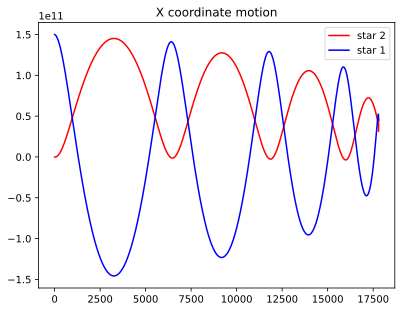

In [7]:
plt.plot(p2[:,0], c='red', label='star 2')
plt.plot(p1[:,0], c='blue', label='star 1')
plt.legend()
plt.title('X coordinate motion')
plt.savefig('x_coord.png')

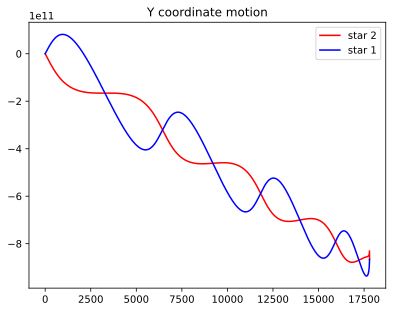

In [8]:
plt.style.use('default')
plt.plot(p2[:,1], c='red', label='star 2')
plt.plot(p1[:,1], c='blue', label='star 1')
plt.legend()
plt.title('Y coordinate motion')
plt.savefig('y_coord.png')

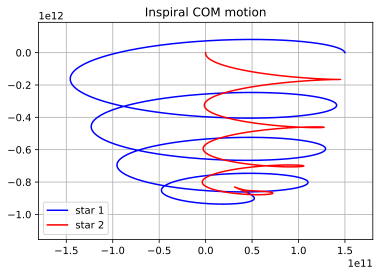

In [57]:
plt.plot(p1[:,0], p1[:,1], c='blue', label='star 1')
plt.plot(p2[:,0], p2[:,1], c='red', label='star 2')
plt.title('Inspiral COM motion')
plt.xlim([-d-d/5, d+d/5])
plt.ylim([-7.7*d, d+d/4])
plt.legend()
plt.savefig('com.png')

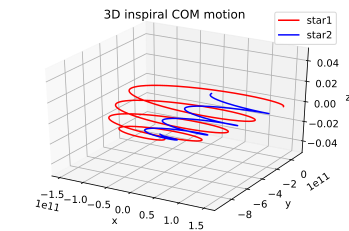

In [40]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.plot(p1[:,0], p1[:,1], p1[:,2], c='red', label='star1')
plt.plot(p2[:,0], p2[:,1], p2[:,2], c='blue', label='star2')
plt.title('3D inspiral COM motion')
plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.savefig('com_3d.png')

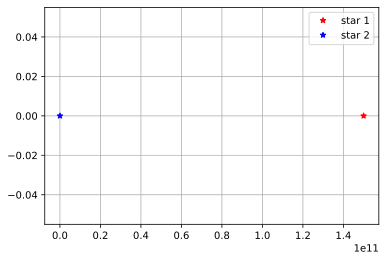

In [55]:
fig,ax = plt.subplots()
plot1, = ax.plot(p1[0,0],p1[0,1], linestyle="", marker="*",color='red', label='star 1')
plot2, = ax.plot(p2[0,0],p2[0,1], linestyle="", marker="*",color='blue', label='star 2')
ax.legend()

def animate(i):
    plot1.set_ydata(p1[i,1])
    plot1.set_xdata(p1[i,0])
    plot2.set_ydata(p2[i,1])
    plot2.set_xdata(p2[i,0])
    plt.title("Iteration: " + str(i))
    ax.set_xlim([-d-d/5, d+d/5])
    ax.set_ylim([-7.7*d, d+d/4])

ani = animation.FuncAnimation(fig, animate, interval=5, frames=len(p1))

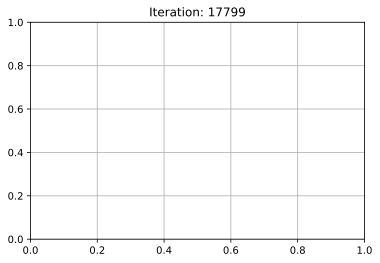

In [56]:
#ani.save("motion_com_v2.mp4") # Save animation

## Move stars

In [ ]:
# If you want a dark background, uncommment this

#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#plt.style.use('dark_background')

In [ ]:
# =================== Simulation Specs for the animation ================== # 
end_time = 1 #N # amount of time that the simulation runs (seconds)
time_per_timestep = .1 # the amount of time, in seconds, that goes by in 1 timestep.
EndTimeStep = end_time/time_per_timestep # number of timesteps of the animation

In [ ]:
# Start center of mass in correct position 
star1_com = star1_list[0] 
star2_com = star2_list[0] 
star_1.move_com(star1_com)
star_2.move_com(star2_com)

# ============== Takes in a list of center of mass positions ============== #
if len(star1_list) != int(EndTimeStep):
    raise ValueError("List of center of mass positions for the first star does not match number of timesteps")
if len(star2_list) != int(EndTimeStep):
    raise ValueError("List of center of mass positions for the second star does not match number of timesteps")
if len(star1_list[0]) != 3:
    raise ValueError("Center of mass coordinates must have dimension 3")
if len(star2_list[0]) != 3:
    raise ValueError("Center of mass coordinates must have dimension 3")
# ========================================================================= # 
# The next few blocks creates an animation with the two stars in 3D.

star1_pos = star_1.getPosition()
star2_pos = star_2.getPosition()
a = np.concatenate((star1_pos,star2_pos)) # start off array of points with just the initial star locations.

# Update the Neutron Star points locations...
for t in range(int(EndTimeStep)): # for every timestep in the simulation
        # -- 0. Update the location of the center of mass -- #
    star_1.move_com(star1_list[t]) # move the stars to their COM locations
    star_2.move_com(star2_list[t])
    # -- 2. update the positions, velocities, and accelerations for this timestep. -- #
    pos1 = star_1.getPosition() # just updating the point locations for now.
    pos2 = star_2.getPosition()
    ### Output Current Star Point positions to pandas dataframe for plotting
    a = np.concatenate((a,pos1)) # add the new star positions for this timestep to the outputed data array for star 1
    a = np.concatenate((a,pos2))# add the new star positions for this timestep to the outputed data array for star 2
    
print("Sucessfully updated and stored star locations.")

num_points1 = star_1.num_points 
num_points2 = star_2.num_points
points_per_timestep = num_points1 + num_points2 # we need to assign the first set of points, (num_points1 + num_points2) points to the same timestep in the movie

points_count = len(a) # Total number of points in the entire simulation
t = np.array([np.ones(points_per_timestep)*i for i in range(int(points_count/points_per_timestep))]).flatten() # an array counting from 0 to 19. Each number repeats 100 times.
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
print("\nSucessfully made plotting dataframe: \n")
print(df)

def update_graph(num):
    data=df[df['time']==num]
    graph._offsets3d = (data.x, data.y, data.z)
    title.set_text('BNS, time={}'.format(num))
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('BNS')
data=df[df['time']==0]
graph = ax.scatter(data.x, data.y, data.z)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, int(EndTimeStep), interval=10, blit=False)

In [ ]:
ani.save("motion2.mp4") # Save animation